# Importing Modules

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from pytorch_lightning.metrics import Accuracy
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import random
%matplotlib inline
device = torch.device('cuda')     # Default CUDA device


# Preparing Data

In [2]:
!!curl -O https://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip
file_path = "fra.txt"

# To change to spanish, just change "fra" to "spa"

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
PAD_token = 0 
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 3  # Count SOS, EOS, PAD
    def addSentence(self, sentence):
        # we could have also used tokenizer from https://huggingface.co/ or spaCy
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def readLangs(file_path,lang1,lang2,reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(file_path, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    print("here we go",pairs[0])
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH    

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(file_path,lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(file_path,lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0]) #which is english
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    pairs = np.asarray(pairs)
    pairs = pairs[:,:2] #ignore the attribution part
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(file_path,'en','fr' ,False)


print(random.choice(pairs))

Reading lines...
here we go ['go .', 'va !']
Read 135842 sentence pairs
Trimmed to 135072 sentence pairs
Counting words...
Counted words:
en 12892
fr 21144
['i hope we ll see each other again sometime .'
 'j espere que nous nous reverrons un jour .']


In [8]:
def tensorFromSentence(lang_obj, sentence):
    sentence_indexes = [lang_obj.word2index[word] for word in sentence.split(' ')]
    sentence_indexes.append(EOS_token)
    return torch.tensor(sentence_indexes, dtype=torch.long).to(device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

print(tensorFromSentence(input_lang,"hello"))
pairs[55],tensorsFromPair(pairs[55])


tensor([[290],
        [  2]], device='cuda:0')


(array(['we won .', 'nous gagnames .'], dtype='<U138'),
 (tensor([[40],
          [16],
          [ 4],
          [ 2]], device='cuda:0'),
  tensor([[83],
          [85],
          [15],
          [ 2]], device='cuda:0')))

# Bahdanau Decoder

In [9]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super().__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = nn.Linear(self.hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

# Encoder Model

In [10]:
class EncoderRNN(pl.LightningModule):
    def __init__(self, input_size, embedding_dim, n_units, n_layers=1):
        super().__init__()
        self.n_units = n_units
        self.n_layers = n_layers
        self.embedding = nn.Embedding(num_embeddings=input_size,embedding_dim=embedding_dim)
        self.gru = nn.GRU(input_size = embedding_dim, hidden_size = n_units, num_layers=n_layers,batch_first =True)

    def forward(self, input, hidden,seq_length):
        embedded = self.embedding(input.to(device)).squeeze(-2).to(device)
        #embedded If batch_first is True, B x T x * input is expected.
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, seq_length.cpu(),batch_first=True,enforce_sorted=True)

        outputs, hidden = self.gru(packed, hidden)
        
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs,batch_first=True)
        return outputs, hidden

    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.n_units).to(device) #(num_layers * num_directions, batch, hidden_size)

# Luong Decoder

In [11]:
class AttnLayer(pl.LightningModule):
    def __init__(self, method, hidden_size):
        super().__init__()
        
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        
        self.hidden_size = hidden_size
        
        self.attn_general = nn.Linear(self.hidden_size, self.hidden_size)

        self.attn_concat = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.v = nn.Parameter(torch.FloatTensor(1, self.hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = torch.zeros(seq_len).to(device) # B x 1 x S

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies,0).unsqueeze(0).unsqueeze(0) #it was oritnally ([20]) but we return it as (1,,1,20)
    
 
    
    def score(self, hidden, encoder_outputs):
        hidden = hidden.squeeze(0)
        encoder_outputs = encoder_outputs.squeeze(0)
        
        if self.method == 'general':
            attn_energies = self.attn_general(encoder_outputs)
            attn_energies = hidden.dot(attn_energies)
        elif self.method == 'concat':
            attn_energies = torch.tanh(self.attn_concat(torch.cat((hidden, encoder_outputs), 1)))
            attn_energies = self.v.dot(attn_energies)
        else:
        #elif self.method == 'dot':
            attn_energies = hidden.dot(encoder_outputs)

        return attn_energies
    

In [17]:
class LuongAttnDecoderRNN(pl.LightningModule):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super().__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size #(num_layers * num_directions, batch, hidden_size), so we should get same hidden size from the prev one
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        # dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
        # Define layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size * 2, self.hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = AttnLayer(attn_model, hidden_size)
    
    def forward(self, input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        embedded = self.embedding(input).view(1, 1, -1) # S= 1 x 1 x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)
        
        # Calculate attention from current Decoder RNN state and all encoder hidden states; 
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        
        #to get the context vector it should be the size of the n.units so we can feed it with the rnn_output
        #bmm needs 3D tensor as the first one must be the batch
        context = attn_weights.bmm(encoder_outputs.unsqueeze(0)) # B x 1 x N
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)),1) #([1, 23334]) for one word only we normalize
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

# Testing Attentions in Decoders

In [18]:


class Seq2seqModel(pl.LightningModule):
    def __init__(self,enc,dec,index2word,n_vocab_target,max_length=MAX_LENGTH):
        super().__init__()
        # need to be (self) in order to be optimized and part of model
        self.encoder = enc
        self.decoder = dec
        self.max_length = max_length
        self.n_vocab_target=n_vocab_target
        self.teacher_forcing_ratio = 0.5
        self.criterion = nn.NLLLoss()
        self.acc = Accuracy()
        self.index2word = index2word
        self.PAD_token = 0 
        self.SOS_token = 1
        self.EOS_token = 2
    def forward(self,input_tensor,target_tensor,seq_length):
        encoder_hidden = self.encoder.initHidden()
        encoder_output, encoder_hidden = self.encoder(input_tensor, encoder_hidden,seq_length) # we pass the seq_length to pack and unpack
        target_length = target_tensor.size(1)  #The max number of words for the target lang
        # now the encoder_output is [1, 4, 64], as each word has n_units, we want the output to be [20,64]
        encoder_outputs = torch.zeros(self.max_length, self.encoder.n_units).to(device)
        for i in range(encoder_output.size(1)):
            encoder_outputs[i] = encoder_output[0,i]
        loss=0
        acc =0
        decoder_input = torch.tensor([[self.SOS_token]]).to(device)# SOS_TOKEN but we pass a value (1) to be a local variable not global in torch script

        decoder_hidden = encoder_hidden

        use_teacher_forcing = torch.rand(1) < self.teacher_forcing_ratio
        decoder_context = torch.zeros(1, self.decoder.hidden_size).to(device)

        decoder_outputs = torch.zeros(target_length, self.n_vocab_target).to(device)

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_context, decoder_hidden, decoder_attn = self.decoder(decoder_input,decoder_context, decoder_hidden, encoder_outputs)
                # loss = nn.NLLLoss(decoder_output, target_tensor[0,di])
                decoder_input = target_tensor[0,di]  # Teacher forcing
                decoder_outputs[di] = decoder_output
                if decoder_input.item() in [self.EOS_token ,self.PAD_token]:
                    break

            # The decoder outputs has the shape (N,C) which is (4 words, 23334 features)
            # target_tensor.squeeze() will be only (N)
            loss = self.criterion(decoder_outputs, target_tensor.squeeze())
            acc=self.acc(torch.argmax(decoder_outputs, dim=1).to(device),target_tensor.squeeze())
            

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_context, decoder_hidden, decoder_attn = self.decoder(decoder_input,decoder_context, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input
                decoder_outputs[di] = decoder_output
                if decoder_input.item() in [self.EOS_token ,self.PAD_token]:
                    break
            loss = self.criterion(decoder_outputs, target_tensor.squeeze())
            acc=self.acc(torch.argmax(decoder_outputs, dim=1),target_tensor.squeeze())
            

        return loss,acc,decoder_outputs

    def training_step(self, batch, batch_idx):
        input_tensor, target_tensor,seq_length = batch
        loss,acc,y_hat =self(input_tensor, target_tensor,seq_length) #y_hat is size (N,C)
        self.log('loss',loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('accuracy',acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         self.logger.experiment.add_graph(self, (input_tensor, target_tensor,seq_length ))
        
        return {'loss': loss,'accuracy':acc}
    
    def translate(self,sentence):
        sentence = normalizeString(sentence)
        input_tensor = tensorFromSentence(input_lang, sentence).unsqueeze(0).to(device)
        seq_lengths = torch.LongTensor(list(map(len, input_tensor))).to(device)
        self.encoder_hidden = self.encoder.initHidden()
        encoder_outputs = torch.zeros(self.max_length, self.encoder.n_units).to(device)

        encoder_output, encoder_hidden = self.encoder(input_tensor, self.encoder_hidden,seq_lengths) # we pass the seq_length to pack and unpack which is how many words
        
        for i in range(encoder_output.size(1)):
            encoder_outputs[i] = encoder_output[0,i]
        decoder_input = torch.tensor([[self.SOS_token]]).to(device)# SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_context = torch.zeros(1, self.decoder.hidden_size).to(device)
        decoder_attentions = torch.zeros(self.max_length, self.max_length).to(device)

        for di in range(self.max_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attn = self.decoder(decoder_input,decoder_context, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attn.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
        decoded_words=' '.join(decoded_words)
        return decoded_words, decoder_attentions[:di + 1]
 

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [20]:
# Padding->DataLoader->Trainer->fit->test
hidden_size = 64
embedding_dim = 256
params = {'shuffle': True,'num_workers': 0,'batch_size':1}
device = torch.device('cuda')     # Default CUDA device
input_tensor = [tensorsFromPair(pair)[0] for pair in pairs[:5]]
# seq_lengths: Gets the actual sequence length of each timestep, this one is from YouTUbe 
seq_lengths = torch.LongTensor(list(map(len, input_tensor))).to(device)
# input_tensor is [100,4,1] 100 word, each is 4 words, each is one feature (which is the index number)
input_tensor = torch.nn.utils.rnn.pad_sequence(input_tensor, batch_first=True).to(device)
target_tensor = [tensorsFromPair(pair)[1] for pair in pairs[:5]]
target_tensor = torch.nn.utils.rnn.pad_sequence(target_tensor, batch_first=True).to(device)


dataset = torch.utils.data.TensorDataset(input_tensor,target_tensor,seq_lengths) # You msut set everything to be in Cuda
train_dataloader  = torch.utils.data.DataLoader(dataset, **params)

print(target_tensor.device)
encoder = EncoderRNN(input_lang.n_words,embedding_dim, hidden_size,n_layers=1).to(device)
attn_decoder = LuongAttnDecoderRNN('general',hidden_size, output_lang.n_words, n_layers=1).to(device)
model = Seq2seqModel(encoder,attn_decoder,output_lang.index2word,output_lang.n_words).to(device)

trainer = pl.Trainer(gpus=1,max_epochs=2,progress_bar_refresh_rate=1,weights_summary='full')
trainer.fit(model,train_dataloader)



# By checking print(("from the model",model.encoder.embedding.weight)) and print(("out of the model",encoder1.embedding.weight))
# We know that passed encoder is trained and the reference is the passed not a new copy

# How to save the model

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


cuda:0



   | Name                      | Type                | Params
-------------------------------------------------------------------
0  | encoder                   | EncoderRNN          | 3.4 M 
1  | encoder.embedding         | Embedding           | 3.3 M 
2  | encoder.gru               | GRU                 | 61.8 K
3  | decoder                   | LuongAttnDecoderRNN | 4.1 M 
4  | decoder.embedding         | Embedding           | 1.4 M 
5  | decoder.gru               | GRU                 | 37.2 K
6  | decoder.out               | Linear              | 2.7 M 
7  | decoder.attn              | AttnLayer           | 12.5 K
8  | decoder.attn.attn_general | Linear              | 4.2 K 
9  | decoder.attn.attn_concat  | Linear              | 8.3 K 
10 | criterion                 | NLLLoss             | 0     
11 | acc                       | Accuracy            | 0     
-------------------------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params

Training: 0it [00:00, ?it/s]

1

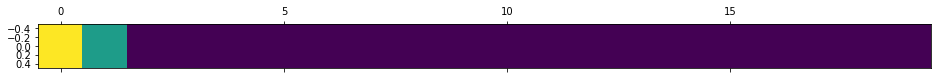

In [21]:
device = torch.device('cpu')     # Default to Cpu after you have finished training

# model.evaluate()
sentence ,attentions = model.translate('run')
PATH = "entire_model.pt"
torch.save(model, PATH)
# model = torch.load(PATH)
plt.matshow(attentions.numpy())



In [34]:
from torchsummaryX import summary
summary(model, x1,x2,x3)

                                     Kernel Shape    Output Shape     Params  \
Layer                                                                          
0_encoder.Embedding_embedding        [256, 14241]  [1, 3, 1, 256]  3.645696M   
1_encoder.GRU_gru                               -         [1, 64]    61.824k   
2_decoder.Embedding_embedding         [64, 23334]      [1, 1, 64]  1.493376M   
3_decoder.GRU_gru                               -      [1, 1, 64]    37.248k   
4_decoder.attn.Linear_attn_general       [64, 64]            [64]      4.16k   
5_decoder.attn.Linear_attn_general       [64, 64]            [64]          -   
6_decoder.attn.Linear_attn_general       [64, 64]            [64]          -   
7_decoder.attn.Linear_attn_general       [64, 64]            [64]          -   
8_decoder.attn.Linear_attn_general       [64, 64]            [64]          -   
9_decoder.attn.Linear_attn_general       [64, 64]            [64]          -   
10_decoder.attn.Linear_attn_general     

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.Embedding_embedding,"[256, 14241]","[1, 3, 1, 256]",3645696.0,3645696.0
1_encoder.GRU_gru,-,"[1, 64]",61824.0,61440.0
2_decoder.Embedding_embedding,"[64, 23334]","[1, 1, 64]",1493376.0,1493376.0
3_decoder.GRU_gru,-,"[1, 1, 64]",37248.0,36864.0
4_decoder.attn.Linear_attn_general,"[64, 64]",[64],4160.0,4096.0
...,...,...,...,...
68_decoder.attn.Linear_attn_general,"[64, 64]",[64],NaN,4096.0
69_decoder.attn.Linear_attn_general,"[64, 64]",[64],NaN,4096.0
70_decoder.Linear_out,"[128, 23334]","[1, 23334]",NaN,2986752.0


In [23]:
from torchviz import make_dot


x1 = torch.randn(1, 3, 1, requires_grad=True).long()
x2 = torch.randn(1, 3, 1,requires_grad=True).long()
x3 = torch.ones(1).long()
loss,acc,y = model(x1,x2,x3)


In [24]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/attention_model')
writer.add_graph(model,[x1,x2,x3])
writer.close()

/rhome/yelnady/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/rhome/yelnady/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/rhome/yelnady/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This 

In [25]:
!tensorboard --logdir=runs --host=localhost --port=6005

2021-02-20 17:33:40.505518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
TensorBoard 2.4.1 at http://localhost:6005/ (Press CTRL+C to quit)
^C


In [ ]:
#requires having graphviz in your path
make_dot(y,params=dict(model.named_parameters())).render("make_dot", format="png")

In [ ]:
from IPython.lib.display import Audio
def beep():
    return Audio('bbc.mp3', autoplay=True)
beep()

In [ ]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js(f'''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''))
    clear_output(False)
    
speak("Code Executed")

In [ ]:
# TorchScript allows you to serialize your models in a way that it can be loaded in non-Python environments. 
# The LightningModule has a handy method to_torchscript() that returns a scripted module which you can save or directly use.


script = model.to_torchscript()
# torch.onnx.export(model, (input_tensor,target_tensor,seq_lengths), "alexnet.onnx", verbose=True)
# save for use in production environment
torch.jit.save(script, "model_done.pt")
# model2.eval()
# scripted_searcher = torch.jit.script(model2(input_tensor,target_tensor,seq_lengths))
# scripted_searcher.save("scripted.pth")


In [ ]:
# # Normal PyTorch


# Evaluating

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Training Functions

## Start Training

In [ ]:
encoder1.load_state_dict(torch.load('enc_saved1'))
encoder1.to(device)
attn_decoder1.load_state_dict(torch.load('dec_saved1'))
attn_decoder1.to(device)
